Remember to change your jupyter kernel to `pytorch-tutorial`.

In [14]:
import os
import struct

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

We first check our configuration, you should see we are using NVIDIA GeForce RTX 4090 if you are using Prof. Chern's computer.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("using", torch.cuda.get_device_name(0))
else:
    print("CUDA unavailable, using CPU")

using NVIDIA GeForce GTX 1660


In [16]:
# read MNIST
def read_mnist(path, load_type="train"):

    def load_mnist_image(filename):
        with open(filename, 'rb') as f:
            _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols) / 255.0 # normalize
            return images[:, np.newaxis, :, :]  # add grayscale dimension (num_images, 1, height, width)

    def load_mnist_label(filename):
        with open(filename, 'rb') as f:
            _, num_labels = struct.unpack(">II", f.read(8)) 
            return np.fromfile(f, dtype=np.uint8)

    if load_type == "train":
        image = load_mnist_image(os.path.join(path, "train-images.idx3-ubyte"))
        label = load_mnist_label(os.path.join(path, "train-labels.idx1-ubyte"))
    elif load_type == "test":
        image = load_mnist_image(os.path.join(path, "t10k-images.idx3-ubyte"))
        label = load_mnist_label(os.path.join(path, "t10k-labels.idx1-ubyte"))
    else:
        print("load type should be either train or test")
        exit(1)
    return image, label

train_image, train_label = read_mnist("../cnn/data", load_type="train")
test_image, test_label = read_mnist("../cnn/data", load_type="test")
print("train image shape:", train_image.shape) 
print("train label shape:", train_label.shape)
print("test image shape:", test_image.shape)  
print("test label shape:", test_label.shape)

train image shape: (60000, 1, 28, 28)
train label shape: (60000,)
test image shape: (10000, 1, 28, 28)
test label shape: (10000,)


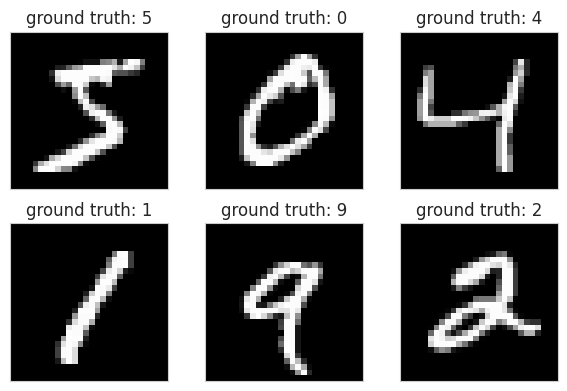

In [17]:
# visualize
fig, ax = plt.subplots(2, 3, figsize=(6, 4))
ax = ax.ravel()
for i in range(6):
  ax[i].imshow(train_image[i][0], cmap='gray', interpolation='none')
  ax[i].set_title("ground truth: {}".format(train_label[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
fig.tight_layout()
fig.show()

In [18]:
# hyperparameters
class Params:
    def __init__(self):
        self.num_epochs = 100
        self.early_stop = 10
        self.batch_size = 128
        self.learn_rate = 0.0005
params = Params()

In [19]:
# create dataloader
train_image = torch.from_numpy(train_image).float()
train_label = torch.from_numpy(train_label).long()
test_image = torch.from_numpy(test_image).float()
test_label = torch.from_numpy(test_label).long()

train_dataset = TensorDataset(train_image, train_label)
test_dataset =  TensorDataset(test_image, test_label)
# split train validation 
train_dataset, valid_dataset = random_split(train_dataset,[50000, 10000])
train_loader = DataLoader(dataset=train_dataset, batch_size=params.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=params.batch_size, shuffle=False)

In [20]:
# define model, loss, and optimizer
class CnnModel(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CnnModel, self).__init__()
        
        self.cnn_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cnn_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.mlp_layer = torch.nn.Sequential(
            torch.nn.Linear(7 * 7 * 32, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = torch.flatten(x, start_dim=1) # flatten image for mlp layer
        x = self.mlp_layer(x)
        return x

model = CnnModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params.learn_rate)
print(model)

CnnModel(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp_layer): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [21]:
class Logger:
    def __init__(self, num_epochs):
        self.train_loss_list = []
        self.valid_loss_list = []
        self.train_acc_list = []
        self.valid_acc_list = []
        self.early_stop = num_epochs

    def write_loss(self, train_loss, valid_loss):
        self.train_loss_list.append(train_loss)
        self.valid_loss_list.append(valid_loss)

    def write_acc(self, train_acc, valid_acc):
        self.train_acc_list.append(train_acc)
        self.valid_acc_list.append(valid_acc)

def compute_accuracy(output, label, gpu=True, grad=False):
    if gpu:
        output = output.cpu()
        label = label.cpu()
    if grad:
        output = output.detach()

    predict_label = torch.argmax(output, dim=1)
    predict_label = predict_label.numpy()
    label = label.numpy()
    return np.mean(predict_label == label)

In [22]:
# train model
early_step = 0
min_valid_loss = 1e10
logger = Logger(params.num_epochs)

for epoch in range(params.num_epochs):    
    train_acc, valid_acc = 0.0, 0.0 
    train_loss, valid_loss = 0.0, 0.0
    # train
    for image, label in tqdm(train_loader, desc="Train [{:2d}/{}]".format(epoch+1, params.num_epochs), unit="batch"):
        # use CUDA if available
        image = image.to(device)
        label = label.to(device)
        # compute output and loss
        output = model(image).squeeze()
        loss = criterion(output, label) 
        # update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update train loss and accuracy
        train_loss += loss.item()
        train_acc += compute_accuracy(output, label, grad=True)
    # validation
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(valid_loader, desc="Valid [{:2d}/{}]".format(epoch+1, params.num_epochs), unit="batch"):
            # use CUDA if available
            image = image.to(device)
            label = label.to(device)
            # compute output and loss
            output = model(image).squeeze() 
            loss = criterion(output, label) 
            # update validation loss and accuracy
            valid_loss += loss.item()
            valid_acc += compute_accuracy(output, label)

    logger.write_loss(train_loss / len(train_loader), valid_loss / len(valid_loader))
    logger.write_acc(train_acc / len(train_loader), valid_acc / len(valid_loader))

    # early stop
    if min_valid_loss > valid_loss: 
        early_step = 0
        min_valid_loss = valid_loss 
        os.makedirs("checkpoints", exist_ok=True)   
        torch.save(model.state_dict(),"checkpoints/model.pth")
    else:
        early_step += 1
        if early_step >= params.early_stop:
            logger.early_stop = epoch - params.early_stop
            print("No improvements for {} consecutive epochs".format(params.early_stop))
            break

Valid [13/100]: 100%|██████████| 79/79 [00:00<00:00, 506.72batch/s]

No improvements for 10 consecutive epochs


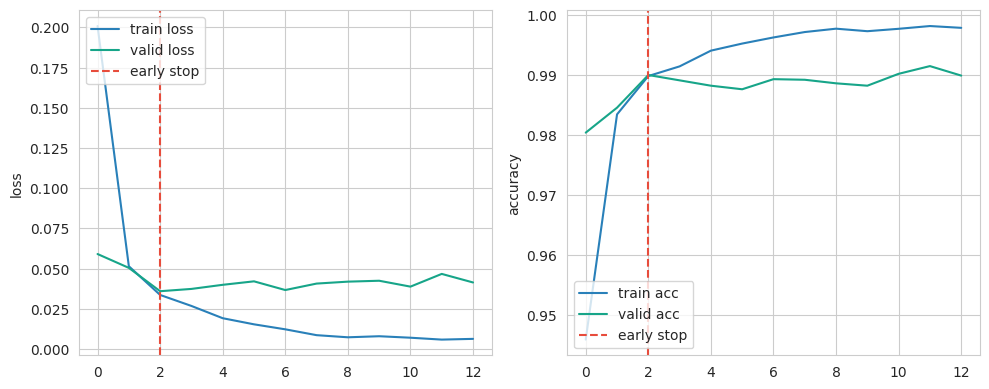

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logger.train_loss_list, color="#2980B9", label="train loss")
ax[0].plot(logger.valid_loss_list, color="#17A589", label="valid loss")
ax[0].axvline(x=logger.early_stop, color="#E74C3C", linestyle='--', label="early stop")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper left")
ax[1].plot(logger.train_acc_list, color="#2980B9", label="train acc")
ax[1].plot(logger.valid_acc_list, color="#17A589", label="valid acc")
ax[1].set_ylabel('accuracy')
ax[1].axvline(x=logger.early_stop, color="#E74C3C", linestyle='--', label="early stop")
ax[1].legend(loc="lower left")
fig.tight_layout()
fig.show()

In [24]:
# inference
model = CnnModel().to(device)
model.load_state_dict(torch.load("checkpoints/model.pth"))
model.eval()  

test_acc = 0.0
with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Test", unit="batch"):
        image = image.to(device)
        label = label.to(device)
        output = model(image).squeeze() 
        test_acc += compute_accuracy(output, label)
    test_acc /= len(test_loader)

print("\nTest Accuracy {:.2f}%".format(100 * test_acc))

Test: 100%|██████████| 79/79 [00:00<00:00, 523.62batch/s]


Test Accuracy 99.06%


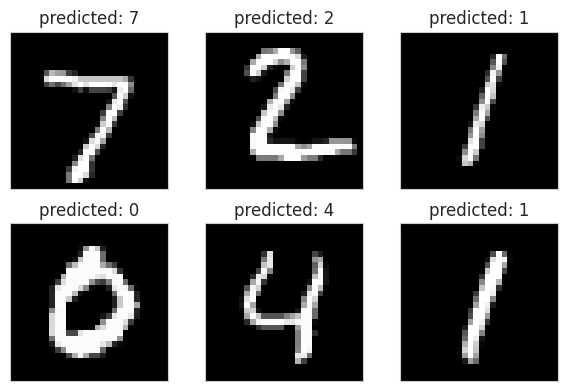

In [25]:
# visualize
fig, ax = plt.subplots(2, 3, figsize=(6, 4))
ax = ax.ravel()
for i in range(6):
    ax[i].imshow(test_image[i][0], cmap='gray', interpolation='none')
    # predict label by model
    with torch.no_grad():
        image = test_image[i].unsqueeze(0).to(device)
        output = model(image).squeeze() 
        predict_label = torch.argmax(output)
    ax[i].set_title("predicted: {}".format(predict_label))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()
fig.show()